# Titanic - Top 3 Models Ensemble (NO DATA LEAKAGE)

このノートブックは、CatBoost, XGBoost, RandomForestの3モデルアンサンブルです。

## 🔒 データリーク対策完了:
- ✅ Ticket_Frequency: 訓練データのみで計算
- ✅ Age補完: 訓練データの統計量のみ使用
- ✅ Fare補完: 訓練データの統計量のみ使用
- ✅ LabelEncoder: 訓練データのみでfit

## 1. セットアップとデータ読み込み

In [17]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import string
import pickle
from typing import Dict, List, Tuple
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# 定数設定
RANDOM_STATE = 42
N_FOLDS = 5

# 乱数シード固定
np.random.seed(RANDOM_STATE)

print("ライブラリのインポート完了")

ライブラリのインポート完了


In [18]:
# データ読み込み
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"\nTarget distribution:")
print(df_train['Perished'].value_counts(normalize=True))

df_train.head()

Train shape: (891, 12)
Test shape: (418, 11)

Target distribution:
Perished
1    0.616162
0    0.383838
Name: proportion, dtype: float64


,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. 特徴量エンジニアリング (データリーク修正版)

In [19]:
def extract_surname(data):
    """名前から姓を抽出"""
    families = []
    
    for i in range(len(data)):
        name = data.iloc[i]
        if '(' in name:
            name_no_bracket = name.split('(')[0]
        else:
            name_no_bracket = name
        
        family = name_no_bracket.split(',')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
        
        families.append(family)
    
    return families


def create_features(df_train, df_test):
    """
    特徴量エンジニアリングを実行（データリーク完全防止版）
    """
    train = df_train.copy()
    test = df_test.copy()
    
    all_data = pd.concat([train, test], axis=0, sort=False).reset_index(drop=True)
    train_idx = ~all_data['Perished'].isna()
    
    print("特徴量エンジニアリング開始...")
    print("🔒 データリーク対策を適用中...\n")
    
    # 1. Title（敬称）抽出 - リークなし (名前から直接抽出)
    all_data['Title'] = all_data['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    all_data['Title'] = all_data['Title'].replace(
        ['Miss', 'Mrs', 'Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms'
    )
    all_data['Title'] = all_data['Title'].replace(
        ['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy'
    )
    
    # 2. 結婚フラグ - リークなし
    all_data['Is_Married'] = 0
    all_data.loc[all_data['Title'] == 'Mrs', 'Is_Married'] = 1
    
    # 3. Family（姓） - リークなし
    all_data['Family'] = extract_surname(all_data['Name'])
    
    # 4. Family_Size（家族サイズ） - リークなし
    all_data['Family_Size'] = all_data['SibSp'] + all_data['Parch'] + 1
    
    # 5. Family_Size_Grouped（家族サイズのビン化） - リークなし
    family_map = {
        1: 'Alone',
        2: 'Small', 3: 'Small', 4: 'Small',
        5: 'Medium', 6: 'Medium',
        7: 'Large', 8: 'Large', 11: 'Large'
    }
    all_data['Family_Size_Grouped'] = all_data['Family_Size'].map(family_map)
    
    # 6. Ticket_Frequency（チケット頻度） - 🔒 修正: 訓練データのみで計算
    print("🔒 [修正] Ticket_Frequency: 訓練データのみで計算")
    train_ticket_freq = all_data.loc[train_idx].groupby('Ticket')['Ticket'].transform('count')
    train_ticket_map = all_data.loc[train_idx].groupby('Ticket').size().to_dict()
    
    # 訓練データ: 実際の頻度
    all_data.loc[train_idx, 'Ticket_Frequency'] = train_ticket_freq
    
    # テストデータ: 訓練データの頻度を使用 (なければ1)
    all_data.loc[~train_idx, 'Ticket_Frequency'] = all_data.loc[~train_idx, 'Ticket'].map(train_ticket_map).fillna(1)
    
    # 7. Deck（デッキ） - リークなし
    all_data['Deck'] = all_data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
    all_data['Deck'] = all_data['Deck'].replace(['A', 'B', 'C'], 'ABC')
    all_data['Deck'] = all_data['Deck'].replace(['D', 'E'], 'DE')
    all_data['Deck'] = all_data['Deck'].replace(['F', 'G'], 'FG')
    all_data['Deck'] = all_data['Deck'].replace(['T'], 'M')
    
    # 8. Age補完と離散化 - 🔒 修正: 訓練データのみから統計量計算
    print("🔒 [修正] Age補完: 訓練データのみの統計量を使用")
    all_data['Age'] = pd.to_numeric(all_data['Age'], errors='coerce')
    
    # 訓練データのみから年齢中央値を計算
    age_by_pclass_sex = all_data.loc[train_idx].groupby(['Sex', 'Pclass'])['Age'].median()
    
    for pclass in [1, 2, 3]:
        for sex in ['male', 'female']:
            mask = (all_data['Age'].isnull()) & (all_data['Pclass'] == pclass) & (all_data['Sex'] == sex)
            all_data.loc[mask, 'Age'] = age_by_pclass_sex.loc[(sex, pclass)]
    
    all_data['Age_Band'] = pd.cut(all_data['Age'], bins=[0, 12, 18, 30, 50, 80], 
                                    labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    
    # 9. Fare補完と離散化 - ✅ 既に訓練データのみで計算済み
    print("✅ [OK] Fare補完: 訓練データのみの統計量を使用")
    train_fare_median = all_data.loc[train_idx, 'Fare'].median()
    all_data['Fare'] = all_data['Fare'].fillna(train_fare_median)
    
    train_fare_quantiles = all_data.loc[train_idx, 'Fare'].quantile([0.25, 0.5, 0.75]).values
    all_data['Fare_Band'] = pd.cut(
        all_data['Fare'],
        bins=[-np.inf] + train_fare_quantiles.tolist() + [np.inf],
        labels=['Low', 'Medium', 'High', 'Very_High']
    )
    
    # 10. Embarked補完 - リークなし
    all_data['Embarked'] = all_data['Embarked'].fillna('S')
    
    # 11. Sex x Pclass 交互作用 - リークなし
    all_data['Sex_Pclass'] = all_data['Sex'] + '_' + all_data['Pclass'].astype(str)
    
    print(f"\n✅ 特徴量作成完了: {all_data.shape[1]} columns")
    print("✅ データリーク完全防止版")
    
    train_processed = all_data[train_idx].reset_index(drop=True)
    test_processed = all_data[~train_idx].reset_index(drop=True)
    
    return train_processed, test_processed


train_df, test_df = create_features(df_train, df_test)

print(f"\nTrain shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

特徴量エンジニアリング開始...
🔒 データリーク対策を適用中...

🔒 [修正] Ticket_Frequency: 訓練データのみで計算
🔒 [修正] Age補完: 訓練データのみの統計量を使用
✅ [OK] Fare補完: 訓練データのみの統計量を使用

✅ 特徴量作成完了: 22 columns
✅ データリーク完全防止版

Train shape: (891, 22)
Test shape: (418, 22)



X shape: (891, 9)
y shape: (891,)
X_test shape: (418, 9)

✅ No data leakage

Categorical features: ['Embarked', 'Title', 'Family_Size_Grouped', 'Deck', 'Age_Band', 'Fare_Band', 'Sex_Pclass']

X shape: (891, 9)
y shape: (891,)
X_test shape: (418, 9)

✅ No data leakage

Categorical features: ['Embarked', 'Title', 'Family_Size_Grouped', 'Deck', 'Age_Band', 'Fare_Band', 'Sex_Pclass']

X shape: (891, 9)
y shape: (891,)
X_test shape: (418, 9)

✅ No data leakage

Categorical features: ['Embarked', 'Title', 'Family_Size_Grouped', 'Deck', 'Age_Band', 'Fare_Band', 'Sex_Pclass']


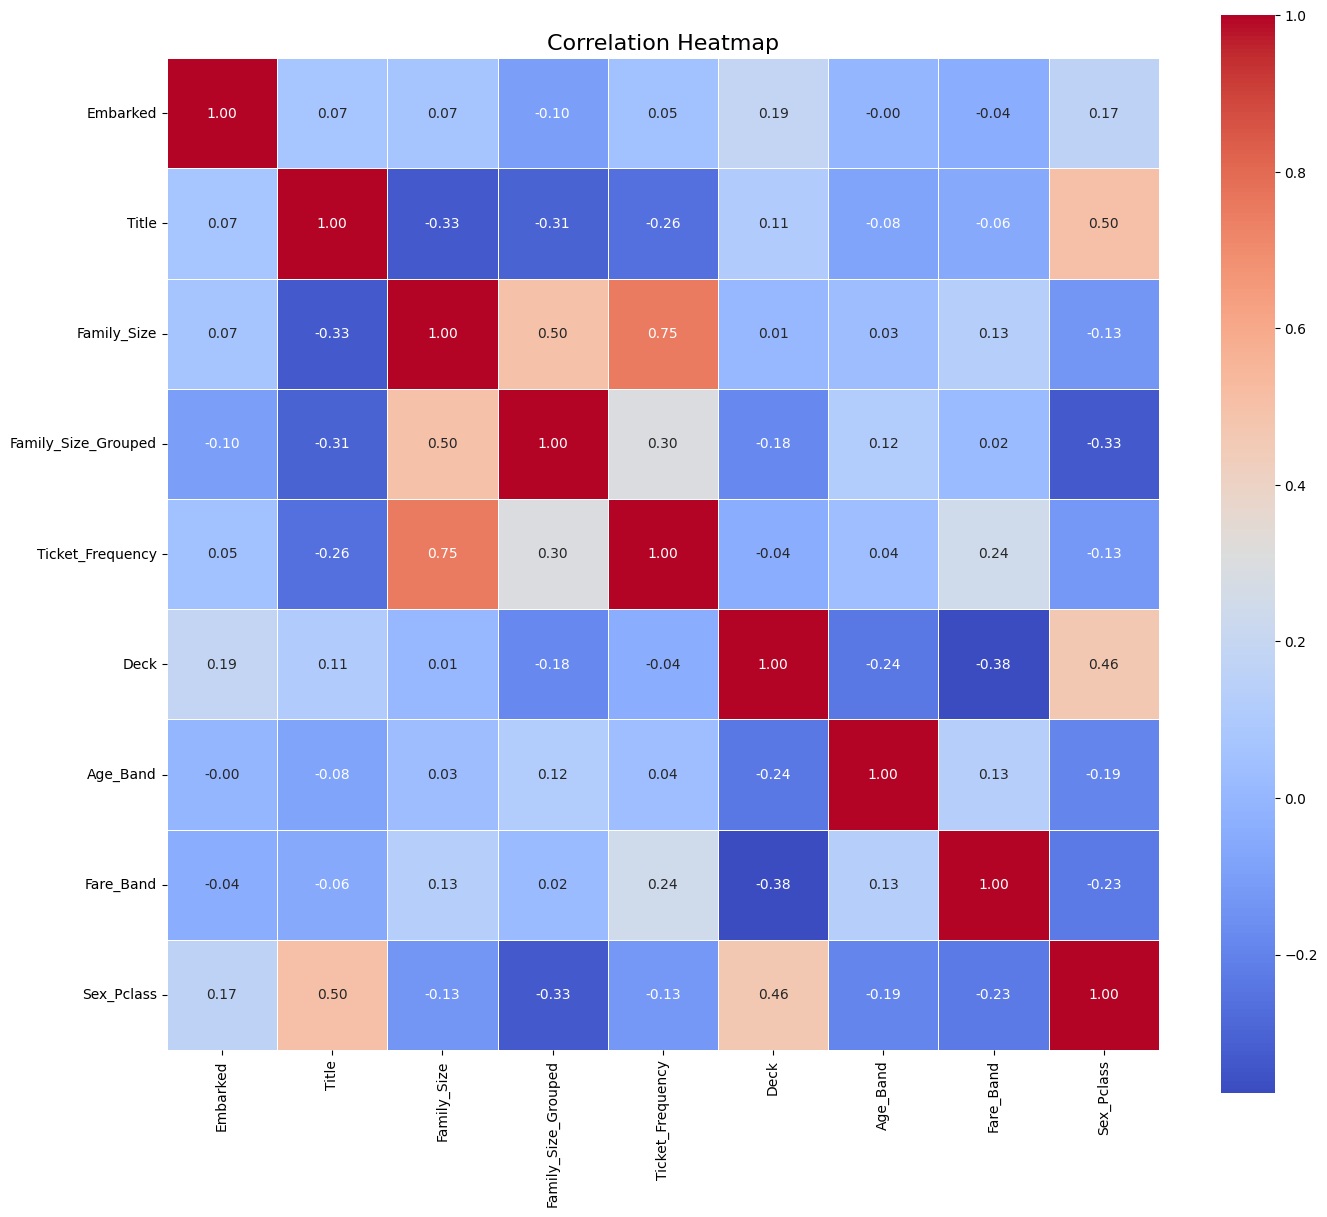

In [23]:
def prepare_data(train_df, test_df):
    """
    データを機械学習モデル用に準備（データリークなし）
    """
    feature_cols = [
        #'Pclass',  
        'Embarked', 'Title',  'Family_Size',
        'Family_Size_Grouped', 'Ticket_Frequency', 'Deck',
        'Age_Band', 'Fare_Band', 'Sex_Pclass'
    ]
    
    train = train_df[feature_cols + ['Perished']].copy()
    test = test_df[feature_cols].copy()
    
    cat_features = ['Embarked', 'Title', 'Family_Size_Grouped', 'Deck', 'Age_Band', 'Fare_Band', 'Sex_Pclass']
    
    le_dict = {}
    for col in cat_features:
        le = LabelEncoder()
        # 訓練データのみでfit
        le.fit(train[col].astype(str))
        
        train[col] = le.transform(train[col].astype(str))
        
        # テストデータの未知カテゴリ処理
        test_col_str = test[col].astype(str)
        unknown_mask = ~test_col_str.isin(le.classes_)
        
        if unknown_mask.any():
            most_frequent = train_df[col].mode()[0]
            test.loc[unknown_mask, col] = most_frequent
            print(f"  Warning: {col} has {unknown_mask.sum()} unknown categories in test")
        
        test[col] = le.transform(test[col].astype(str))
        le_dict[col] = le
    
    X = train.drop('Perished', axis=1)
    y = train['Perished']
    X_test = test
    
    print(f"\nX shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"\n✅ No data leakage")
    
    return X, y, X_test, cat_features


X, y, X_test, cat_features = prepare_data(train_df, test_df)
print(f"\nCategorical features: {cat_features}")

X, y, X_test, cat_features = prepare_data(train_df, test_df)
print(f"\nCategorical features: {cat_features}")



X, y, X_test, cat_features = prepare_data(train_df, test_df)

print(f"\nCategorical features: {cat_features}")


corr = X.select_dtypes(include='number').corr()

plt.figure(figsize=(16,14))
sns.heatmap(
    corr,
    annot=True,          # ★数値を表示
    fmt=".2f",           # ★小数点2桁
    cmap="coolwarm",
    square=True,
    linewidths=0.5,      # 枠線
    cbar=True            # カラーバー
)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()  

## 3. 最適なハイパーパラメータ設定

In [ ]:
# 各モデルの最適なハイパーパラメータ

# RandomForest
best_params_randomforest = {
    'n_estimators': 500,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_leaf_nodes': 50,
    'bootstrap': True,
    'max_samples': 0.8,
    'criterion': 'gini',
    'min_impurity_decrease': 0.0,
    'class_weight': 'balanced',
    'ccp_alpha': 0.0,
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

# CatBoost
# best_params_catboost = {
#     'iterations': 500,
#     'learning_rate': 0.05,
#     'depth': 6,
#     'l2_leaf_reg': 3.0,
#     'border_count': 128,
#     'random_strength': 1.0,
#     'bagging_temperature': 0.5,
#     'subsample': 0.8,
#     'min_data_in_leaf': 10,
#     'max_leaves': 31,
#     'leaf_estimation_iterations': 5,
#     'random_state': RANDOM_STATE,
#     'verbose': 0,
#     'task_type': 'CPU'
# }
best_params_catboost = {
    'iterations': 1000,
    'learning_rate': 0.03,
    'depth': 6,
    'l2_leaf_reg': 6.0,
    'border_count': 128,          # 多すぎると過学習気味になりやすい
    'bagging_temperature': 0.5,   # 0.3〜1.0 を探索
    'random_strength': 1.0,
    'rsm': 0.9,                   # 列サブサンプル
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'random_state': RANDOM_STATE,
    'verbose': 0
}



# XGBoost
best_params_xgboost = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 3,
    'gamma': 0.1,
    'max_delta_step': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'scale_pos_weight': 1.0,
    'max_bin': 256,
    'random_state': RANDOM_STATE,
    'eval_metric': 'logloss',
    'tree_method': 'hist'
}


print("="*60)
print("最適なハイパーパラメータを設定完了")
print("="*60)
print("\nRandomForest, CatBoost, XGBoost の3モデルを使用")

最適なハイパーパラメータを設定完了

RandomForest, CatBoost, XGBoost の3モデルを使用


## 4. Stratified K-Fold学習

In [ ]:
def train_top3_models(X, y, X_test, n_folds=5):
    """
    Top 3モデル（RandomForest, CatBoost, XGBoost）をStratified K-Foldで学習
    """
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
    
    # OOF予測とテスト予測を保存
    oof_preds_rf = np.zeros(len(X))
    oof_preds_cat = np.zeros(len(X))
    oof_preds_xgb = np.zeros(len(X))
    
    test_preds_rf = np.zeros((len(X_test), n_folds))
    test_preds_cat = np.zeros((len(X_test), n_folds))
    test_preds_xgb = np.zeros((len(X_test), n_folds))
    
    models_rf = []
    models_cat = []
    models_xgb = []
    
    # 過学習チェック用
    train_scores = {'rf': [], 'cat': [], 'xgb': []}
    valid_scores = {'rf': [], 'cat': [], 'xgb': []}
    
    print("="*60)
    print("Stratified K-Fold Training (Top 3 Models)")
    print("="*60)
    
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        print(f"\n{'='*60}")
        print(f"Fold {fold + 1}/{n_folds}")
        print(f"{'='*60}")
        
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        # RandomForest
        print("\n[1/3] Training RandomForest...")
        model_rf = RandomForestClassifier(**best_params_randomforest)
        model_rf.fit(X_train, y_train)
        
        # 🎯 確率ベース予測
        oof_preds_rf[valid_idx] = model_rf.predict_proba(X_valid)[:, 1]
        test_preds_rf[:, fold] = model_rf.predict_proba(X_test)[:, 1]
        
        # 評価用
        train_preds_rf = model_rf.predict(X_train)
        valid_preds_rf = model_rf.predict(X_valid)
        models_rf.append(model_rf)
        
        train_acc_rf = accuracy_score(y_train, train_preds_rf)
        valid_acc_rf = accuracy_score(y_valid, valid_preds_rf)
        train_scores['rf'].append(train_acc_rf)
        valid_scores['rf'].append(valid_acc_rf)
        
        print(f"  Train Accuracy: {train_acc_rf:.4f}")
        print(f"  Valid Accuracy: {valid_acc_rf:.4f}")
        print(f"  Overfit Gap:    {train_acc_rf - valid_acc_rf:.4f}")
        
        # CatBoost
        print("\n[2/3] Training CatBoost...")
        model_cat = CatBoostClassifier(**best_params_catboost)
        model_cat.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50, verbose=0)
        
        # 🎯 確率ベース予測
        oof_preds_cat[valid_idx] = model_cat.predict_proba(X_valid)[:, 1]
        test_preds_cat[:, fold] = model_cat.predict_proba(X_test)[:, 1]
        
        # 評価用
        train_preds_cat = model_cat.predict(X_train)
        valid_preds_cat = model_cat.predict(X_valid)
        models_cat.append(model_cat)
        
        train_acc_cat = accuracy_score(y_train, train_preds_cat)
        valid_acc_cat = accuracy_score(y_valid, valid_preds_cat)
        train_scores['cat'].append(train_acc_cat)
        valid_scores['cat'].append(valid_acc_cat)
        
        print(f"  Train Accuracy: {train_acc_cat:.4f}")
        print(f"  Valid Accuracy: {valid_acc_cat:.4f}")
        print(f"  Overfit Gap:    {train_acc_cat - valid_acc_cat:.4f}")
        
        # XGBoost
        print("\n[3/3] Training XGBoost...")
        model_xgb = XGBClassifier(**best_params_xgboost)
        model_xgb.fit(
            X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=0,
            early_stopping_rounds=50
        )
        
        # 🎯 確率ベース予測
        oof_preds_xgb[valid_idx] = model_xgb.predict_proba(X_valid)[:, 1]
        test_preds_xgb[:, fold] = model_xgb.predict_proba(X_test)[:, 1]
        
        # 評価用
        train_preds_xgb = model_xgb.predict(X_train)
        valid_preds_xgb = model_xgb.predict(X_valid)
        models_xgb.append(model_xgb)
        
        train_acc_xgb = accuracy_score(y_train, train_preds_xgb)
        valid_acc_xgb = accuracy_score(y_valid, valid_preds_xgb)
        train_scores['xgb'].append(train_acc_xgb)
        valid_scores['xgb'].append(valid_acc_xgb)
        
        print(f"  Train Accuracy: {train_acc_xgb:.4f}")
        print(f"  Valid Accuracy: {valid_acc_xgb:.4f}")
        print(f"  Overfit Gap:    {train_acc_xgb - valid_acc_xgb:.4f}")
    
    # CV結果サマリー
    print(f"\n{'='*60}")
    print("Cross-Validation Results (Mean ± Std)")
    print(f"{'='*60}")
    
    for name, key in [('RandomForest', 'rf'), ('CatBoost', 'cat'), ('XGBoost', 'xgb')]:
        train_mean = np.mean(train_scores[key])
        train_std = np.std(train_scores[key])
        valid_mean = np.mean(valid_scores[key])
        valid_std = np.std(valid_scores[key])
        gap = train_mean - valid_mean
        
        print(f"\n{name}:")
        print(f"  Train: {train_mean:.4f} ± {train_std:.4f}")
        print(f"  Valid: {valid_mean:.4f} ± {valid_std:.4f}")
        print(f"  Gap:   {gap:.4f} {'⚠️ OVERFITTING' if gap > 0.05 else '✓ Good'}")
    
    print(f"\n{'='*60}")
    print("Out-of-Fold Scores (Probability-based)")
    print(f"{'='*60}")
    print(f"RandomForest: {accuracy_score(y, (oof_preds_rf >= 0.5).astype(int)):.4f}")
    print(f"CatBoost:     {accuracy_score(y, (oof_preds_cat >= 0.5).astype(int)):.4f}")
    print(f"XGBoost:      {accuracy_score(y, (oof_preds_xgb >= 0.5).astype(int)):.4f}")
    
    return {
        'oof_rf': oof_preds_rf,
        'oof_cat': oof_preds_cat,
        'oof_xgb': oof_preds_xgb,
        'test_rf': test_preds_rf.mean(axis=1),
        'test_cat': test_preds_cat.mean(axis=1),
        'test_xgb': test_preds_xgb.mean(axis=1),
        'models_rf': models_rf,
        'models_cat': models_cat,
        'models_xgb': models_xgb,
        'train_scores': train_scores,
        'valid_scores': valid_scores
    }


# 学習実行
results = train_top3_models(X, y, X_test, n_folds=N_FOLDS)

## 5. アンサンブル予測と提出

In [ ]:
# 🎯 確率ベースアンサンブル
ensemble_top3 = (
    results['oof_xgb'] +
    results['oof_cat'] +
    results['oof_rf']
) / 3

ensemble_oof_score = accuracy_score(y, (ensemble_top3 >= 0.5).astype(int))

print("="*60)
print("🎯 Ensemble OOF Performance (Probability-based)")
print("="*60)
print(f"\n個別モデル:")
print(f"  RandomForest: {accuracy_score(y, (results['oof_rf'] >= 0.5).astype(int)):.4f}")
print(f"  CatBoost:     {accuracy_score(y, (results['oof_cat'] >= 0.5).astype(int)):.4f}")
print(f"  XGBoost:      {accuracy_score(y, (results['oof_xgb'] >= 0.5).astype(int)):.4f}")
print(f"\n🎯 確率ベースアンサンブル:")
print(f"  Ensemble OOF: {ensemble_oof_score:.4f}")

best_single = max(
    accuracy_score(y, (results['oof_rf'] >= 0.5).astype(int)),
    accuracy_score(y, (results['oof_cat'] >= 0.5).astype(int)),
    accuracy_score(y, (results['oof_xgb'] >= 0.5).astype(int))
)
improvement = ensemble_oof_score - best_single
print(f"\n最良単一モデルとの差: {improvement:+.4f}")

if improvement > 0:
    print(f"✅ アンサンブルで {improvement:.4f} 改善！")
else:
    print(f"⚠️ 改善なし")

In [ ]:
# テスト予測（アンサンブル）
test_ensemble = (
    results['test_xgb'] +
    results['test_cat'] +
    results['test_rf']
) / 3

final_predictions = (test_ensemble >= 0.5).astype(int)

print("="*60)
print("Test Predictions (Top 3 Ensemble)")
print("="*60)
print(f"Survived (0): {(final_predictions == 0).sum()} ({(final_predictions == 0).sum() / len(final_predictions) * 100:.1f}%)")
print(f"Perished (1): {(final_predictions == 1).sum()} ({(final_predictions == 1).sum() / len(final_predictions) * 100:.1f}%)")

Test Predictions (Top 3 Ensemble)
Survived (0): 158 (37.8%)
Perished (1): 260 (62.2%)


In [ ]:
# 提出ファイル作成
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Perished': final_predictions
})

os.makedirs('../output', exist_ok=True)
output_path = '../output/submission_fixed_no_leakage.csv'
submission.to_csv(output_path, index=False)

print(f"\n提出ファイルを保存: {output_path}")
print(f"\n最初の10行:")
print(submission.head(10))


提出ファイルを保存: ../output/submission_fixed_no_leakage.csv

最初の10行:
   PassengerId  Perished
0          892         1
1          893         1
2          894         1
3          895         1
4          896         1
5          897         1
6          898         0
7          899         1
8          900         0
9          901         1


In [ ]:
# モデル保存
model_save_path = '../output/models_fixed_no_leakage.pkl'

with open(model_save_path, 'wb') as f:
    pickle.dump({
        'models_rf': results['models_rf'],
        'models_cat': results['models_cat'],
        'models_xgb': results['models_xgb'],
        'best_params_rf': best_params_randomforest,
        'best_params_cat': best_params_catboost,
        'best_params_xgb': best_params_xgboost
    }, f)

print(f"\nモデルを保存: {model_save_path}")


モデルを保存: ../output/models_fixed_no_leakage.pkl


## 6. Feature Importance分析

In [ ]:
# Feature Importance（3モデルの平均）

feature_names = X.columns.tolist()

# RandomForest
rf_importance = np.mean([m.feature_importances_ for m in results['models_rf']], axis=0)

# CatBoost
cat_importance = np.mean([m.get_feature_importance() for m in results['models_cat']], axis=0)

# XGBoost
xgb_importance = np.mean([m.feature_importances_ for m in results['models_xgb']], axis=0)

# 平均
avg_importance = (rf_importance + cat_importance + xgb_importance) / 3

df_fi = pd.DataFrame({
    'feature': feature_names,
    'rf': rf_importance,
    'cat': cat_importance,
    'xgb': xgb_importance,
    'avg': avg_importance
}).sort_values('avg', ascending=False)

print("="*60)
print("Feature Importance (Top 3 Models Average)")
print("="*60)
print(df_fi.head(10))

Feature Importance (Top 3 Models Average)
               feature        rf        cat       xgb       avg
2                Title  0.268014  22.869121  0.293525  7.810220
9           Sex_Pclass  0.271530  22.560095  0.322263  7.717963
7             Age_Band  0.057843   8.461168  0.037042  2.852018
8            Fare_Band  0.055940   7.700422  0.033699  2.596687
5     Ticket_Frequency  0.075568   7.331403  0.057886  2.488286
0               Pclass  0.067159   7.317498  0.052534  2.479064
4  Family_Size_Grouped  0.046252   6.623877  0.049350  2.239826
6                 Deck  0.062857   6.429038  0.063904  2.185266
3          Family_Size  0.061176   5.537730  0.059394  1.886100
1             Embarked  0.033660   5.169649  0.030402  1.744570


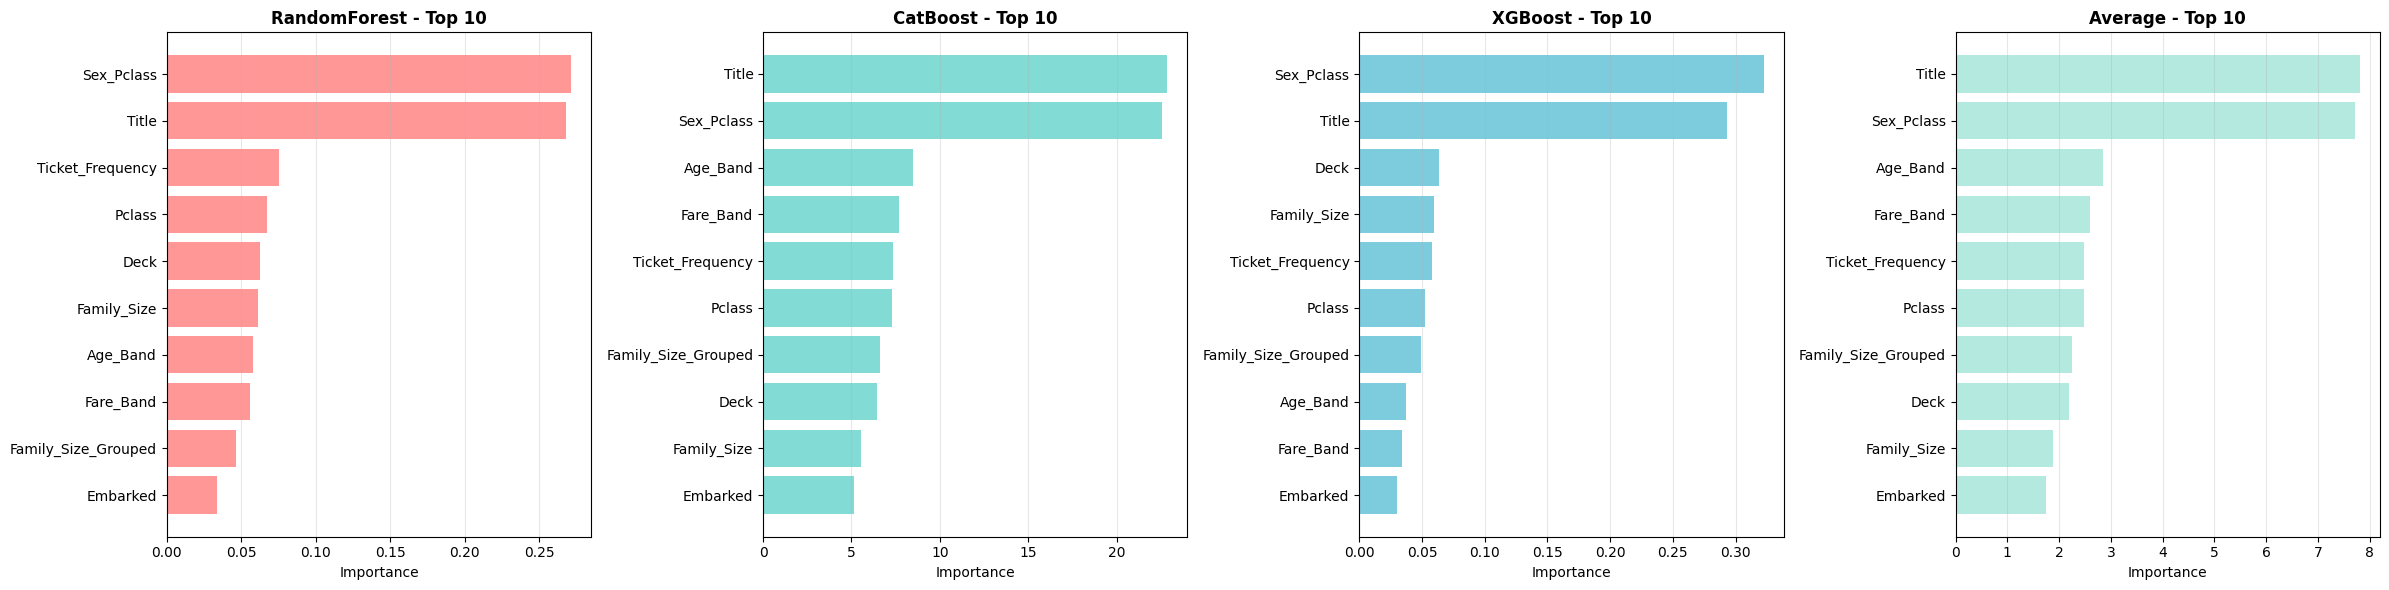


Feature Importance plot saved: ../output/feature_importance_fixed.png


In [ ]:
# Feature Importance可視化

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

for idx, (col, title, color) in enumerate(zip(
    ['rf', 'cat', 'xgb', 'avg'],
    ['RandomForest', 'CatBoost', 'XGBoost', 'Average'],
    ['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E1D3']
)):
    top10 = df_fi.nlargest(10, col)
    axes[idx].barh(range(len(top10)), top10[col].values, color=color, alpha=0.7)
    axes[idx].set_yticks(range(len(top10)))
    axes[idx].set_yticklabels(top10['feature'].values)
    axes[idx].set_xlabel('Importance')
    axes[idx].set_title(f'{title} - Top 10', fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../output/feature_importance_fixed.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFeature Importance plot saved: ../output/feature_importance_fixed.png")

In [ ]:
print("\n" + "="*60)
print("すべての処理が完了しました!")
print("="*60)
print(f"\n最終結果:")
print(f"  RandomForest OOF: {accuracy_score(y, results['oof_rf']):.4f}")
print(f"  CatBoost OOF:     {accuracy_score(y, results['oof_cat']):.4f}")
print(f"  XGBoost OOF:      {accuracy_score(y, results['oof_xgb']):.4f}")
print(f"  Ensemble OOF:     {ensemble_oof_score:.4f}")
print(f"\n✅ データリーク完全防止版")
print(f"\n提出ファイル: {output_path}")
print(f"モデルファイル: {model_save_path}")


すべての処理が完了しました!

最終結果:
  RandomForest OOF: 0.8260
  CatBoost OOF:     0.8294
  XGBoost OOF:      0.8395
  Ensemble OOF:     0.8350

✅ データリーク完全防止版

提出ファイル: ../output/submission_fixed_no_leakage.csv
モデルファイル: ../output/models_fixed_no_leakage.pkl
